In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

**Checking the Availability of GPU in the colab Notebook using cuda library and instructing it to use GPU for processing**

In [2]:

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print( torch.cuda.device_count())
    print('Available:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1
Available: Tesla T4


**Installing the required libraries required**

In [3]:
!pip install wget
!pip install transformers

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=497aa6bf178618a183a8c7eb909e1fb78d00444b4b881235a76e98d26cdc359b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 1.4MB 8.4MB/s 
     |████████████████████████████████| 2.9MB 51.9MB/s 
     |████████████████████████████████| 890kB 46.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=9a8e532382936e282484e740adec07fd62a124b1da5e5a33f07891a8e8e97f87
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


**Downloading the datasets**

In [4]:
url_train='https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio'
url_test='https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio'


In [5]:
import wget
import os

In [6]:
wget.download(url_train)

'engtrain.bio'

In [7]:
wget.download(url_test)

'engtest.bio'

**Appending all the row lines from bio format file using csvreader() function**

In [8]:
import csv
sentences = []
labels = []

tokens = []
token_labels = []
unique_labels = set()

with open("./engtrain.bio", newline = '') as lines:                                                                                          
  
    line_reader = csv.reader(lines, delimiter='\t')
    
    for line in line_reader:
        
        if line == []:

            sentences.append(tokens)
            labels.append(token_labels)           
    
            tokens = []
            token_labels = []        

        else: 

            tokens.append(line[1])
            token_labels.append(line[0])

            unique_labels.add(line[0])

            

**Sentences Output**

In [9]:
  

[  print(' '.join(sentences[i])) for i in range(10)]

what movies star bruce willis
show me films with drew barrymore from the 1980s
what movies starred both al pacino and robert deniro
find me all of the movies that starred harold ramis and bill murray
find me a movie with a quote about baseball in it
what movies have mississippi in the title
show me science fiction films directed by steven spielberg
do you have any thrillers directed by sofia coppola
what leonard cohen songs have been used in a movie
show me films elvis films set in hawaii


[None, None, None, None, None, None, None, None, None, None]

**Sample Input Sentence**

In [10]:
' '.join(sentences[1])

'show me films with drew barrymore from the 1980s'

In [11]:
pd.DataFrame({"Word":sentences[1],"Labels":labels[1]})

,Word,Labels
0,show,O
1,me,O
2,films,O
3,with,O
4,drew,B-ACTOR
5,barrymore,I-ACTOR
6,from,O
7,the,O
8,1980s,B-YEAR


In [12]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 9,775


**Preparing input text data for Feeding it into BERT model by converting and spilting the text into tokens and mapping the tokens using BertTokenizer functon**

In [13]:
from transformers import BertTokenizer
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
tokenizer.encode(sentences[1])

[101, 2265, 2033, 3152, 2007, 3881, 100, 2013, 1996, 3865, 102]

In [15]:
tokenizer.decode([101, 2265, 2033, 3152, 2007, 3881, 100, 2013, 1996, 3865, 102])

'[CLS] show me films with drew [UNK] from the 1980s [SEP]'

**Calculating of length of each tokenized sentences**

In [16]:
TokenLength=[len(tokenizer.encode(' '.join(i),add_special_tokens=True)) for i in sentences]

In [17]:
print('Minimum  length: {:,} tokens'.format(min(TokenLength)))
print('Maximum length: {:,} tokens'.format(max(TokenLength)))
print('Median length: {:,} tokens'.format(int(np.median(TokenLength))))

Minimum  length: 3 tokens
Maximum length: 51 tokens
Median length: 12 tokens


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


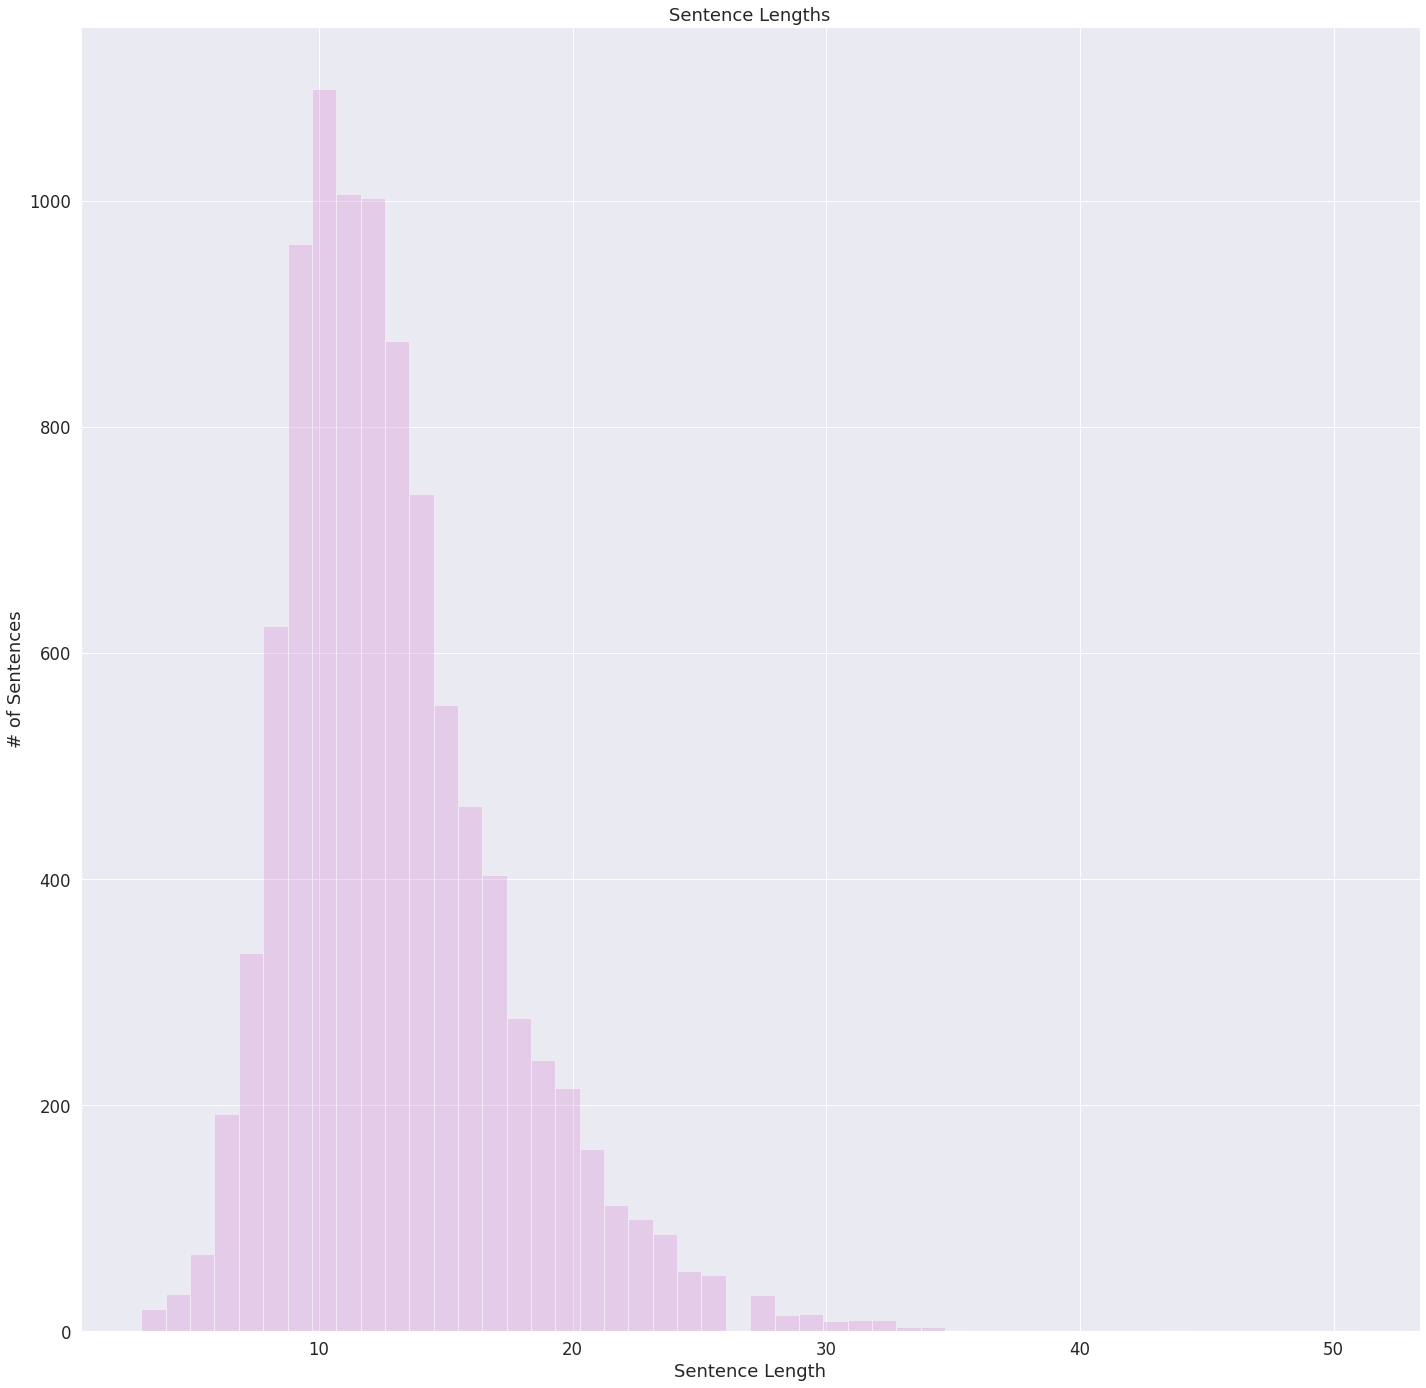

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24,24))
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.distplot(TokenLength, kde=False, rug=False,color='plum')

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences');

**Now we must include Padding [PAD] token in the input so every tokens should be of same length. We have selected max length of PAD token to be 55 (as max is 51)**

In [19]:
#Sample Sentence
SampleSentence=tokenizer.encode_plus(' '.join(sentences[1]), add_special_tokens = True,truncation = True,max_length = 50,padding = True,return_attention_mask = True, return_tensors = 'pt')
SampleSentence

{'input_ids': tensor([[ 101, 2265, 2033, 3152, 2007, 3881, 6287, 5974, 2013, 1996, 3865,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
##input_ids
print("\nInput Ids:",SampleSentence["input_ids"])
##attention_mask
print("\nAttention Mask:",SampleSentence["attention_mask"])


Input Ids: tensor([[ 101, 2265, 2033, 3152, 2007, 3881, 6287, 5974, 2013, 1996, 3865,  102]])

Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


**Mapping Label**

In [21]:
label_map = {}

for (i, label) in enumerate(unique_labels):
    
    # Map it to its integer
    label_map[label] = i

**Adding Attention Mask**

In [22]:

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)
    encoded_dict = tokenizer.encode_plus(
                        sent_str,                 
                        add_special_tokens = True,
                        truncation = True,
                        max_length = 55,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
        
    input_ids.append(encoded_dict['input_ids'][0])
    
    # And its attention mask
    attention_masks.append(encoded_dict['attention_mask'][0])

print('Original: ', sentences[24])
print('Token IDs:', input_ids[24])
print('Masks:', attention_masks[24])

Original:  ['find', 'the', 'movies', 'action', 'movies', 'directed', 'by', 'john', 'woo', 'from', 'the', '1990s']
Token IDs: tensor([  101,  2424,  1996,  5691,  2895,  5691,  2856,  2011,  2198, 15854,
         2013,  1996,  4134,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])


In [23]:
new_labels = []

# The special label ID we'll give to "extra" tokens.
null_label_id = -100

for (sen, orig_labels) in zip(input_ids, labels):
    
    padded_labels = []

    orig_labels_i = 0 

    for token_id in sen:

        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            padded_labels.append(null_label_id)

        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            padded_labels.append(null_label_id)

        else:
            
            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

            orig_labels_i += 1

    assert(len(sen) == len(padded_labels))    

    new_labels.append(padded_labels)


In [24]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', new_labels[2])
print('\nMask:        ', attention_masks[2])


Sentence:     ['what', 'movies', 'starred', 'both', 'al', 'pacino', 'and', 'robert', 'deniro']

Labels:       ['O', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR', 'O', 'B-ACTOR', 'I-ACTOR']

BERT Tokens:  ['what', 'movies', 'starred', 'both', 'al', 'pac', '##ino', 'and', 'robert', 'den', '##iro']

Token IDs:    tensor([  101,  2054,  5691,  5652,  2119,  2632, 14397,  5740,  1998,  2728,
         7939,  9711,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])

New Labels:   [-100, 13, 13, 13, 13, 7, 4, -100, 13, 7, 4, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100

**Convert the lists into PyTorch tensors using torch.stack**

In [25]:

# Concatenates a sequence of tensors along a new dimension
# [7,660  x  50].
pt_input_ids = torch.stack(input_ids, dim=0)

pt_attention_masks = torch.stack(attention_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [26]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,797 training samples
  978 validation samples


**Convert tensors into Batches for batch wise training and using RandomSampler for selecting the batch Randomly**

In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )

validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size   )

**Using 12 Layer BERT Model for out task**

In [28]:
from transformers import BertForTokenClassification, AdamW, BertConfig


model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(label_map) + 1, output_attentions = False, output_hidden_states = False)


model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [29]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )


In [30]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs 
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [31]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    total_loss = 0

    model.train()
    
    for step, batch in enumerate(train_dataloader):
       
        if step % 40 == 0 and not step == 0:
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.43
======== Epoch 2 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.18
======== Epoch 3 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.13
======== Epoch 4 / 4 ========
Training...
  Batch    40  of    275.
  Batch    80  of    275.
  Batch   120  of    275.
  Batch   160  of    275.
  Batch   200  of    275.
  Batch   240  of    275.
  Average training loss: 0.10


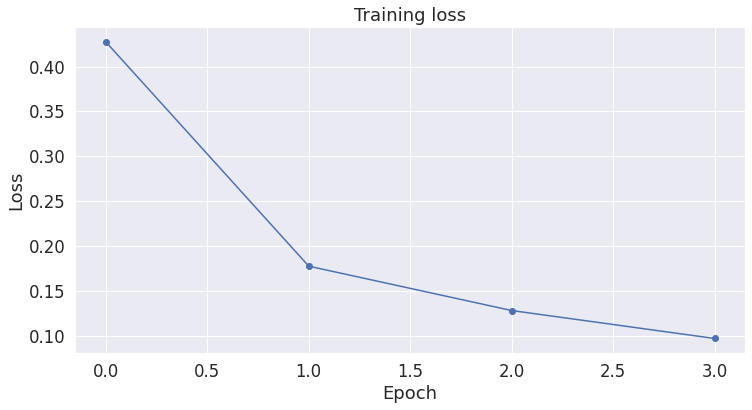

In [32]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

**Preparing the Test dataset same as training dataset for predicting the results of our Trained model**

In [33]:
import csv

# List of all sentences in the dataset.
sentences = []
labels = []

# Lists to store the current sentence.
tokens = []
token_labels = []
unique_labels = set()

with open("./engtest.bio", newline = '') as lines:                                                                                          
    
    line_reader = csv.reader(lines, delimiter='\t')
    
    for line in line_reader:
        
        if line == []:

            sentences.append(tokens)
            labels.append(token_labels)           
    
            tokens = []
            token_labels = []        

        else: 

            tokens.append(line[1])
            token_labels.append(line[0])
            unique_labels.add(line[0])

In [34]:

input_ids = []
attention_masks = []

for sent in sentences:

    sent_str = ' '.join(sent)

    encoded_dict = tokenizer.encode_plus(sent_str,add_special_tokens = True, max_length = 50,pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
       
    input_ids.append(encoded_dict['input_ids'][0])
    
    attention_masks.append(encoded_dict['attention_mask'][0])

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Masks:', attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  ['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now']
Token IDs: tensor([  101,  2024,  2045,  2151,  2204,  6298, 22092,  2041,  2157,  2085,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [35]:
new_labels = []

null_label_id = -100

for (sen, orig_labels) in zip(input_ids, labels):
    
    padded_labels = []

    orig_labels_i = 0 

    for token_id in sen:
        
        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):
            
            padded_labels.append(null_label_id)

        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':

            padded_labels.append(null_label_id)

        else:
            

            label_str = orig_labels[orig_labels_i]

            padded_labels.append(label_map[label_str])

            orig_labels_i += 1

    assert(len(sen) == len(padded_labels))    

    new_labels.append(padded_labels)


In [36]:
print('\nSentence:    ', sentences[2])
print('\nLabels:      ', labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nMask:        ', attention_masks[2])
print('\nNew Labels:  ', new_labels[2])


Sentence:     ['list', 'the', 'five', 'star', 'rated', 'movies', 'starring', 'mel', 'gibson']

Labels:       ['O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS_AVERAGE', 'O', 'O', 'O', 'B-ACTOR', 'I-ACTOR']

BERT Tokens:  ['list', 'the', 'five', 'star', 'rated', 'movies', 'starring', 'mel', 'gibson']

Token IDs:    tensor([  101,  2862,  1996,  2274,  2732,  6758,  5691,  4626, 11463,  9406,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

New Labels:   [-100, 13, 13, 19, 1, 13, 13, 13, 7, 4, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

In [37]:

pt_input_ids = torch.stack(input_ids, dim=0)

pt_attention_masks = torch.stack(attention_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [38]:
batch_size = 32  

prediction_data = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

**Prediction on test set**

In [39]:


print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,443 test sentences...
    DONE.


In [40]:
from sklearn.metrics import f1_score

# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels. 

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape) 


# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)


After flattening the batches, the predictions have shape:
     (2443, 50, 26)

After choosing the highest scoring label for each token:
     (2443, 50)

After flattening the sentences, we have predictions:
     (122150,)
and ground truth:
     (122150,)


In [41]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))


Before filtering out `null` tokens, length = 122,150
 After filtering out `null` tokens, length = 24,686


In [42]:
from sklearn.metrics import f1_score

f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 

print ("F1 score: {:.2%}".format(f1))

F1 score: 94.45%


# **Testing the Trained Model**

In [64]:
test_sentence = input ("Enter number :") 


Enter number :Characterized by its use of Technicolor, fantasy storytelling, musical score, and memorable characters, the film has become an American pop culture icon. It was nominated for six Academy Awards, including Best Picture, but lost to Gone with the Wind, also directed by Fleming.


## ***Checking the Results*** 

In [65]:

#Encoding and convert the sentences into tensors
sample_sentence = tokenizer.encode(test_sentence)
sample_input_ids = torch.tensor([sample_sentence]).cuda()

#Predicting the test data set using model() function
with torch.no_grad():
    output = model(sample_input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

#Function which retrieves key value for our Label Dictionary
def get_key(val):
    for key, value in label_map.items():
         if val == value:
             return key
 
    return "key doesn't exist"

#Tokenize  
tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])
new_tokens, new_label = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_label.append(get_key(label_idx))
        new_tokens.append(token)

#Appending Tokens and Labels
movie_token=[]
movie_label=[]
for token, label in zip(new_tokens, new_label):
    movie_token.append(token) 
    movie_label.append(label)

df=pd.DataFrame({"Token":movie_token,"Movie_Label":movie_label})
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
Token,[CLS],characterized,by,its,use,of,technicolor,",",fantasy,storytelling,",",musical,score,",",and,memorable,characters,",",the,film,has,become,an,american,pop,culture,icon,.,it,was,nominated,for,six,academy,awards,",",including,best,picture,",",but,lost,to,gone,with,the,wind,",",also,directed,by,fleming,.,[SEP]
Movie_Label,O,O,O,O,O,O,O,O,B-GENRE,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,I-GENRE,I-GENRE,O,O,O,O,O,O,B-RATINGS_AVERAGE,O,O,O,O,O,O,O,O,O,O,B-TITLE,I-TITLE,I-TITLE,I-TITLE,O,O,O,O,I-DIRECTOR,O,O


In [ ]:
import joblib
filename = 'F:\IE Courses\Deep Learning and Neural Network\Assignments\Project\final_model.h5'
joblib.dump(model, filename)
 



In [ ]:
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)

In [ ]:
labels[1]

In [ ]:
test_sentence=' '.join(sentences[1])